In [1]:
from system import TradingEnv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from itertools import chain
import numpy as np

import random
import math
from tqdm import tqdm

/home/aaruran/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
e = TradingEnv()

In [4]:
STATE_DIM = len(e.reset())
ACTION_DIM = 3
EPISODES = 2000  # number of episodes
EPS_START = 0.9  # e-greedy threshold start value
EPS_END = 0.05  # e-greedy threshold end value
EPS_DECAY = 200  # e-greedy threshold decay
GAMMA = 0.99  # Q-learning discount factor
LR = 0.001  # NN optimizer learning rate
HIDDEN_LAYER = 10  # NN hidden layer size
BATCH_SIZE = 500  # Q-learning batch size
TARGET_UPDATE = 100  # frequency of target update
BUFFER_SIZE = 10000  # capacity of the replay buffer 

# if gpu is to be used
# use_cuda = torch.cuda.is_available()
use_cuda = False
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

In [5]:
del e

In [6]:
if use_cuda:
    print('GPU found and in use')
else:
    print('No GPU will be used')

No GPU will be used


# Simple QNetwork 
Corresponds to a fully connected network with two hidden layers

In [7]:
class QNetwork(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(STATE_DIM, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, ACTION_DIM)

    def forward(self, x):
        """
            Computes the estimated Q-values for a given batch x
        """
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x      
    
    def sample_from_softmax_policy(self, batch_state):
        batch_q_values = self.forward(batch_state)
        batch_pi = F.softmax(batch_q_values, dim=1)
        batch_size = batch_pi.shape[0]
        batch_actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            pi = batch_pi[i, :]
            dist = torch.distributions.Categorical(pi)
            # Subtract 1, so batch_actions is in {-1, 0, 1}
            batch_actions[i, 0] = dist.sample().view(1,1) - 1
        if use_cuda:
            batch_actions = batch_actions.to(batch_state.get_device())
        return batch_actions.long()

# Generic Training Agent

In [92]:
class BaseAgent:
    def __init__(self, gamma=0.8):
        assert 0 < gamma < 1, f"Invalid gamma: {gamma}" 
        self.gamma = gamma
        self.memory = ReplayMemory(BUFFER_SIZE)
        self.rewards_history = []
        self.steps_done = 0
        
    def run_episode(self, environment):
        """
            Takes an env, and trains the agent until the environment
            reaches a terminal state (ie the training window is complete).
        """
        raise NotImplementedError()
    
    def plot_cumulative_discounted_rewards(self):
        rewards = np.array(self.rewards_history)
        discount_array = np.power(0.8, np.arange(rewards.shape[0]))
        plt.plot((discount_array[:, None] * rewards).sum(axis=1))
        plt.grid()
        plt.ylabel('Cumulative Discounted Rewards')
        plt.xlabel('Episode')

    def convert_action(self, action):
        """
            Takes action of shape 1 x 3, and converts into an integer in {-1, 0, 1}.
            This integer is the position short/hold/long respectively.
        """
        position = torch.argmax(action, dim=-1) - 1
        assert position in [-1,0,1]
        return position
        
class DQN(BaseAgent):
    def __init__(self):
        super().__init__()
        self.model = QNetwork()
        self.target = QNetwork()
        self.optimizer = optim.Adam(self.model.parameters(), LR)

    def select_epsilon_greedy_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.target(state).data.max(1)[1].view(1, 1)
        else:
            return LongTensor([[random.randrange(3)]])
    
    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        action = None
        while True:
#             if steps % 50 == 0:
#                 print(f'steps = {steps}')
            state_tensor = FloatTensor([state])
            action = self.select_epsilon_greedy_action(state_tensor)
            position = self.convert_action(action)
            next_state, reward, done, _ = environment.step(position)
#             print(f'action = {action}')            
#             print(f'position = {position}')
#             print(f'next_state length = {len(next_state)}')
#             print(f'reward = {reward}')
            self.memory.push((FloatTensor([state]),
                         action,  # action is already a tensor
                         FloatTensor([next_state]),
                         FloatTensor([reward]),
                         FloatTensor([int(done)])))

            self.learn()
            if self.steps_done % TARGET_UPDATE == 0:
                self.target.load_state_dict(self.model.state_dict())
        
            state = next_state
            steps += 1
            if done:
                break
        self.rewards_history.append(environment.rewards_list)
        
    def max_next_q_values(self, batch_next_state):
        # expected Q values are estimated from actions which gives maximum Q value
        return self.target(batch_next_state).detach().max(1)[0]
    
    def learn(self):
        if len(self.memory) <= BATCH_SIZE:
            return
        # random transition batch is taken from experience replay memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        batch_done = Variable(torch.cat(batch_done))

        # current Q values are estimated by NN for all actions
        current_q_values = self.model(batch_state).gather(1, batch_action).squeeze()
        expected_future_rewards = self.max_next_q_values(batch_next_state)
        
        expected_q_values = batch_reward + (self.gamma * expected_future_rewards) * (1-batch_done)

        # loss is measured from error between current and newly expected Q values
        loss = F.mse_loss(current_q_values, expected_q_values)

        # backpropagation of loss to QNetwork
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    
# agent=DQN()
# env = TradingEnv()
# for i in range(10):
#     s = FloatTensor([env.reset()])
#     agent.steps_done=100
#     print(agent.select_epsilon_greedy_action(s))

# agent.run_episode(env)

In [72]:
with open('sp500.txt', 'r') as src:
    filtered_tickers = src.read().split(',')

In [74]:
# env = TradingEnv()
# plt.plot(env.rewards_list)
for i in tqdm(range(failed-12, len(filtered_tickers))):
#     ticker = random.choice(filtered_tickers)
    ticker = filtered_tickers[i  % len(filtered_tickers)]
#     print(f'Training on {ticker}')
    try:
        env = TradingEnv(ticker=ticker)
        agent.run_episode(env)
    except KeyError:
        print(ticker)
# agent.plot_cumulative_discounted_rewards()

 52%|█████▏    | 34/65 [02:09<01:30,  2.93s/it]

VIAC


100%|██████████| 65/65 [04:05<00:00,  3.77s/it]


In [69]:
ticker

'TT'

In [75]:
import pandas as pd
from pandas_datareader import data
data.DataReader('FOXA', 'yahoo')

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-12,38.000000,38.000000,38.000000,38.000000,10000.0,37.231663
2019-03-13,39.900002,38.700001,39.000000,39.750000,20477400.0,38.946278
2019-03-14,41.400002,39.750000,39.750000,40.650002,6248600.0,39.828079
2019-03-15,41.869999,41.240002,41.380001,41.700001,7107300.0,40.856846
2019-03-18,41.950001,41.049999,41.950001,41.700001,4020900.0,40.856846
...,...,...,...,...,...,...
2020-07-06,27.290001,26.120001,27.010000,26.500000,5096700.0,26.500000
2020-07-07,26.379999,25.629999,26.240000,25.690001,3815000.0,25.690001
2020-07-08,25.670000,24.995001,25.580000,25.299999,4276500.0,25.299999


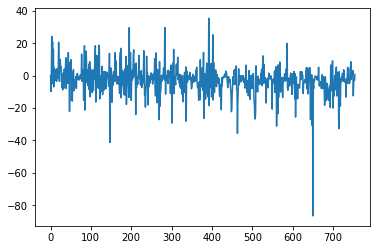

In [78]:
plt.plot(agent.rewards_history[-1])

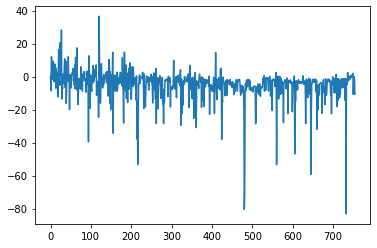

In [79]:
plt.plot(agent.rewards_history[0])

In [12]:
%load_ext line_profiler

In [13]:
e = TradingEnv()

In [14]:
# %lprun -f agent.run_episode [agent.run_episode(e) for _ in range(50)]

In [15]:
# _ = e.reset()
# %lprun -f e.step e.step(1)

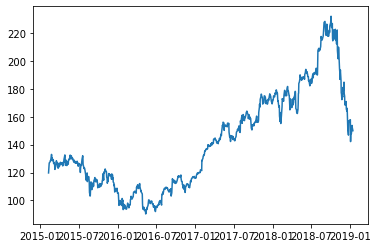

In [16]:
plt.plot(e.prices)

# Policy Network

In [ ]:
class PolicyNetwork(nn.Module):
    # for Policy-Gradient methods, e.g. actor-only and actor-critic methods
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
        self.l3 = nn.Linear(HIDDEN_LAYER, 2) # 2, for the action

    def forward(self, x, d=1, get_log=False):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        if not get_log:
            x = F.softmax(self.l3(x), dim=d)
        else:
            x = F.log_softmax(self.l3(x), dim=d)
        return x
    
    def sample_from_softmax_policy(self, batch_state):
        batch_pi = self.forward(batch_state)
        batch_size = batch_pi.shape[0]
        actions = torch.empty(batch_size, 1)
        for i in range(batch_size):
            pi = batch_pi[i, :]
            dist = torch.distributions.Categorical(pi)
            actions[i, 0] = dist.sample().view(1,1)
        if use_cuda:
            actions = actions.to(batch_state.get_device())
        return actions.long()

# p = PolicyNetwork()
# state = env.reset()
# state_tensor = FloatTensor([state]).cuda()
# p.cuda()
# p.forward(state_tensor, d=1), p.forward(state_tensor, d=-1)
# p.sample_from_softmax_policy(torch.cat(5*[state_tensor])).shape

# LongOnly Agent

In [102]:
class LongOnlyAgent(BaseAgent):
    def __init__(self):
        super().__init__()
        
    def run_episode(self, environment):
        state = environment.reset()
        steps = 0
        position = 1
        while True:
#             if steps % 50 == 0:
#                 print(f'steps = {steps}')
            _, r, done, __ = environment.step(position)

            self.steps_done += 1
            steps += 1
            if done:
                break
        self.rewards_history.append(environment.rewards_list)

# long_agent = LongOnlyAgent()
# e = TradingEnv()
# long_agent.run_episode(e)
# # long_agent.rewards_history
# long_agent.run_episode(e)

In [105]:
for i in tqdm(range(len(filtered_tickers))):
# for i in tqdm(range(10)):
#     ticker = random.choice(filtered_tickers)
    ticker = filtered_tickers[i  % len(filtered_tickers)]
#     print(f'Training on {ticker}')
    try:
        env = TradingEnv(ticker=ticker)
        long_agent.run_episode(env)
    except KeyError:
        print('skipping', ticker)

  5%|▌         | 27/493 [00:29<08:48,  1.14s/it]/home/aaruran/Documents/Git/rl-course/project/system.py:122: RuntimeWarning: invalid value encountered in double_scalars
  
/home/aaruran/Documents/Git/rl-course/project/system.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  sigma_prev = self.data["std"][self.df_index - 2]
/home/aaruran/Documents/Git/rl-course/project/system.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/aaruran/Documents/Git/rl-course/project/system.py:124: RuntimeWarning: invalid value encountered in double_scalars
  sigma_prev = self.data["std"][self.df_index - 2]
 94%|█████████▎| 462/493 [08:19<00:24,  1.25it/s]

skipping VIAC


100%|██████████| 493/493 [08:51<00:00,  1.08s/it]


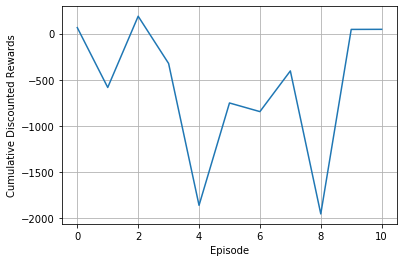

In [104]:
long_agent.plot_cumulative_discounted_rewards()

In [97]:
long_agent.rewards_history

[]